In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ta

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

sns.set()

Using TensorFlow backend.


# Antonio Rosolia: Task for Quantitative Research Intern

## 1a) Import Data and preprocess

In [2]:
data = pd.read_csv("dataset.csv")
data.rename(columns={data.columns[0]: "DATE" }, inplace = True)
data["DATE"] = pd.to_datetime(data["DATE"], format="%d/%m/%Y")
data.set_index("DATE", inplace=True, drop=True)
data.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823
1993-02-03,529400.0,44.406412,44.843856,44.375026,312.672265
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975


### Data Checks

In [3]:
data[data.isna().any(axis=1)]

,VOLUME,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
1993-02-15,NaN,NaN,NaN,NaN,NaN
1993-04-09,NaN,NaN,NaN,NaN,NaN
1993-05-31,NaN,NaN,NaN,NaN,NaN
1993-07-05,NaN,NaN,NaN,NaN,NaN
1993-09-06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-07-04,NaN,NaN,NaN,NaN,NaN
2018-09-03,NaN,NaN,NaN,NaN,NaN
2018-11-22,NaN,NaN,NaN,NaN,NaN


There are some rows Nans. After checking the dates, these seem to be the trading holidays of NYSE, so we can drop them

In [4]:
data = data.dropna()

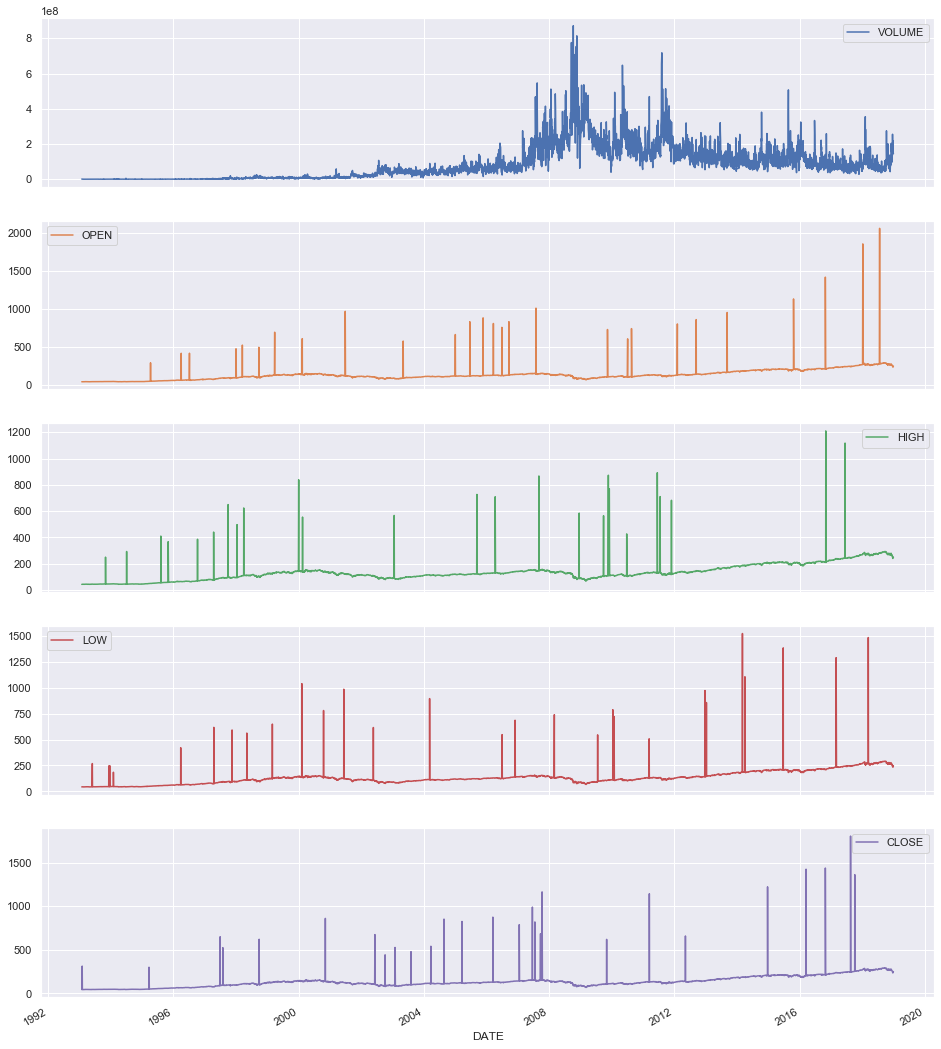

In [5]:
fig = data.plot(subplots=True, figsize=(16,20), sharex=True)

We can clearly see, that the columns OPEN, HIGH, LOW, COSE have some error in it. Since i am not an expert on this data and i do not know where it came from and why there are significant errors in it, I consider this a human made error (probably to test me :D). A simple solution, which is sufficient for this task, is to check the difference between the value and it's lagged value and afterwards calculate the z-score. If the z-score is bigger than 2, it is considered as an outlier, which will be replaced by it's previous value.

In [6]:
for i in range(1, len(data.columns)):
    values = data.iloc[:,i]

    #calculate the difference between y_t and y_(t-1) (dorpna, as the first value has no lagging value)
    diff = (values-values.shift(-1)).dropna().to_numpy()

    mean = np.mean(diff)
    std = np.std(diff)

    #all indexes with a z-socre greater than 3 are considered ouliers and are included in the list
    false_index = np.argwhere((diff-mean)/std>2)
    false_index = false_index.flatten()
    
    data.iloc[false_index,i] = data.iloc[false_index-1,i].values
    print("For column " + data.columns[i] + " " +  str(len(false_index)) + " values have been replaced.")

For column OPEN 27 values have been replaced.
For column HIGH 25 values have been replaced.
For column LOW 28 values have been replaced.
For column CLOSE 27 values have been replaced.


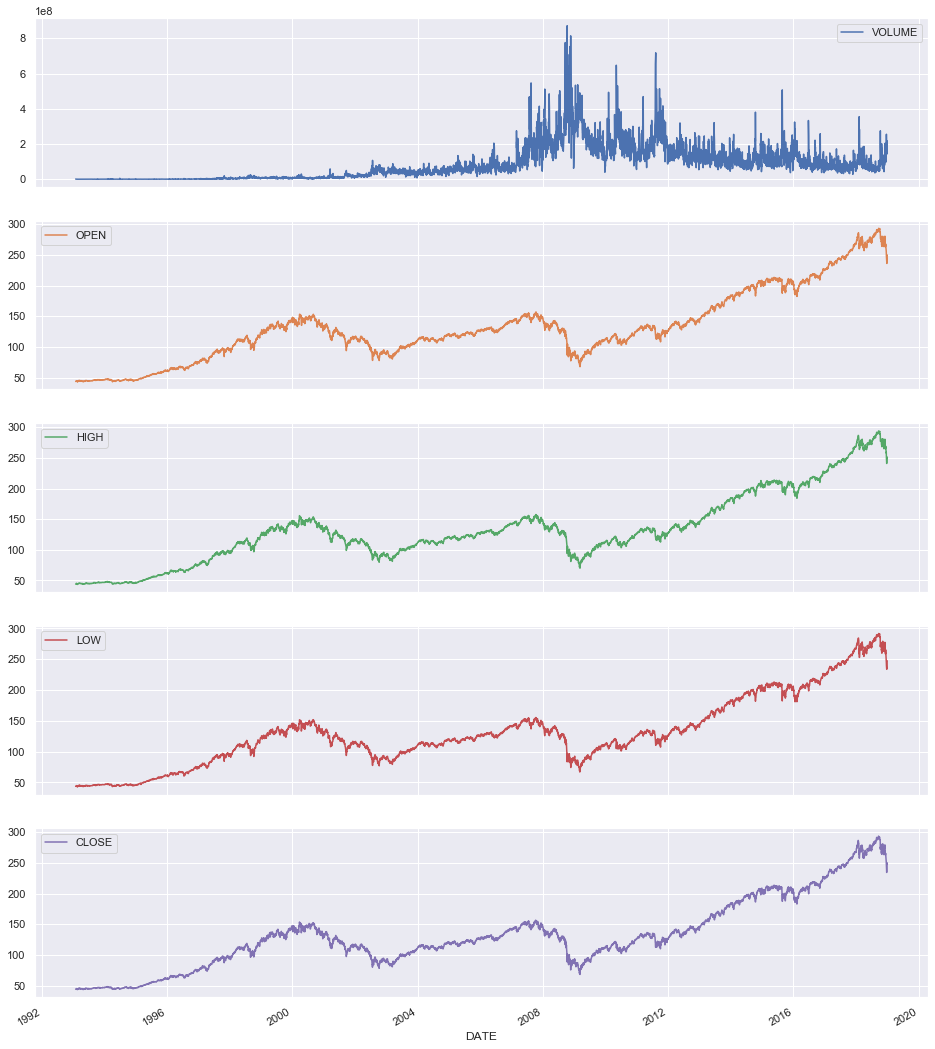

In [7]:
fig = data.plot(subplots=True, figsize=(16,20), sharex=True)

Much better! One last check with the summary statistics and we are good to go.

In [8]:
data.describe()

,VOLUME,OPEN,HIGH,LOW,CLOSE
count,6.528000e+03,6528.000000,6528.000000,6528.000000,6528.000000
mean,8.464678e+07,131.087569,131.857312,130.223934,131.079172
std,9.930732e+07,56.613516,56.786797,56.409509,56.604451
min,5.200000e+03,43.343783,43.531347,42.687527,43.406185
25%,6.739850e+06,95.840755,96.671866,94.953123,95.658757
50%,5.631290e+07,123.495010,124.150000,122.494918,123.415039
75%,1.245619e+08,149.320362,150.270037,148.219999,149.303484
max,8.715469e+08,293.090082,293.940040,291.810007,293.579985


## 1c) Feature engineering

In [9]:
df = data.copy(deep=True)
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975


In [10]:
df["Mid"] = (df["HIGH"]+df["LOW"])/2
df["Return"]= (df["CLOSE"]-df["CLOSE"].shift(1))/df["CLOSE"].shift(1)*100
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Mid,Return
DATE,,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,43.859475,NaN
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,44.109271,0.711487
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,44.249936,0.211800
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,44.609441,0.000000
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,44.984339,1.479691


In [35]:
df["Return"].describe()

count    6495.000000
mean        0.033090
std         1.157782
min        -9.844706
25%        -0.457633
50%         0.052810
75%         0.567269
max        14.519763
Name: Return, dtype: float64

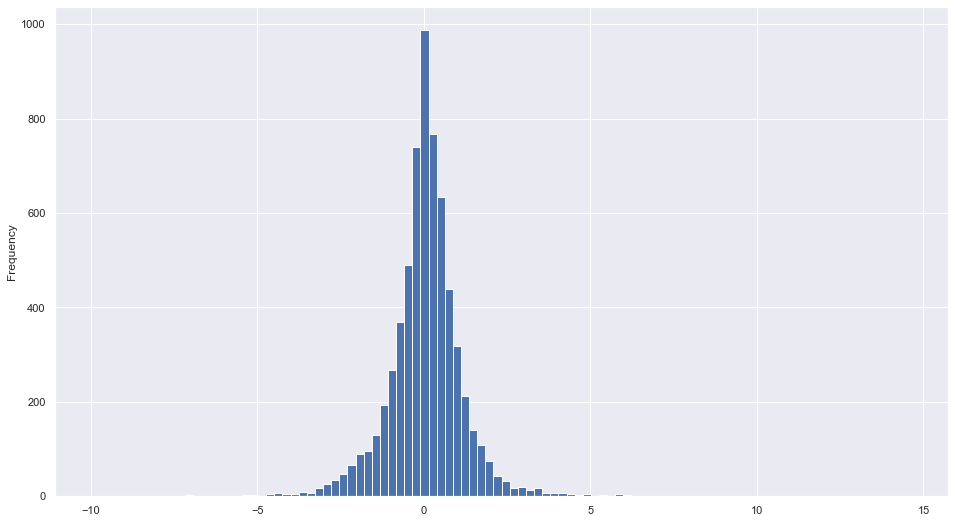

In [34]:
df["Return"].plot(kind="hist", figsize=(16,9), bins=100)

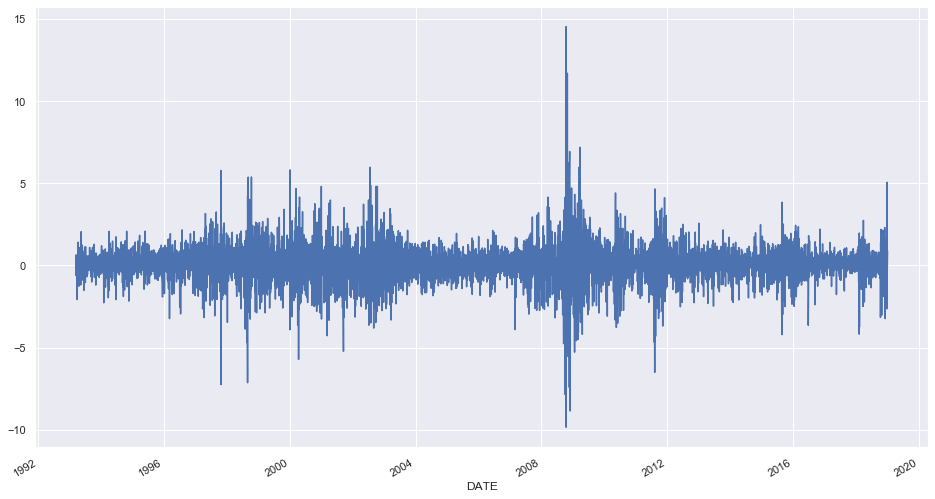

In [39]:
df["Return"].plot(kind="line", figsize=(16,9))

Now let's add lagging features of the features we already have.

In [11]:
for col in df.columns.values:
    for i in range(1,31):
        df[col+"-"+str(i)] = df[col].shift(i)
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Mid,Return,VOLUME-1,VOLUME-2,VOLUME-3,...,Return-21,Return-22,Return-23,Return-24,Return-25,Return-26,Return-27,Return-28,Return-29,Return-30
DATE,,,,,,,,,,,,,,,,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,43.859475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,44.109271,0.711487,1003200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,44.249936,0.211800,480500.0,1003200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,44.609441,0.000000,201300.0,480500.0,1003200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,44.984339,1.479691,529400.0,201300.0,480500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
volume = df["VOLUME"]
open = df["OPEN"]
high = df["HIGH"]
low = df["LOW"]
close = df["CLOSE"]

df["AwesomeOscillator"] = ta.momentum.AwesomeOscillatorIndicator(high, low).awesome_oscillator()
df["Williams"] = ta.momentum.WilliamsRIndicator(high, low, close).williams_r()
df["Ichimoku_senkou_a"] = ta.trend.IchimokuIndicator(high, low).ichimoku_a()
df["Ichimoku_senkou_b"] = ta.trend.IchimokuIndicator(high, low).ichimoku_b()
df["Ichimoku_kijun"] = ta.trend.IchimokuIndicator(high, low).ichimoku_base_line() 
df["Ichimoku_tenkan"] = ta.trend.IchimokuIndicator(high, low).ichimoku_conversion_line()

lagging_t = [2,3,5,10,15,20,30]
for lag in lagging_t:
    df["ROC-"+str(lag)] = ta.momentum.ROCIndicator(close, window = lag).roc()
    df["RSI-"+str(lag)] = ta.momentum.RSIIndicator(close, window = 14).rsi()
    df["ATR-"+str(lag)] = ta.volatility.AverageTrueRange(high, low, close, window=lag).average_true_range()
    df["CCI-"+str(lag)] = ta.trend.CCIIndicator(high, low, close, window=lag).cci()
    df["EMA-"+str(lag)] = ta.trend.EMAIndicator(close, window = lag).ema_indicator()

df.tail(n=5)

,VOLUME,OPEN,HIGH,LOW,CLOSE,Mid,Return,VOLUME-1,VOLUME-2,VOLUME-3,...,ROC-20,RSI-20,ATR-20,CCI-20,EMA-20,ROC-30,RSI-30,ATR-30,CCI-30,EMA-30
DATE,,,,,,,,,,,,,,,,,,,,,
2018-12-24,147311588.0,239.039843,240.835650,234.270065,234.340087,237.552857,-2.642306,255345633.0,252053377.0,214992763.0,...,-10.981910,18.936170,5.635112,-206.027708,258.254158,-16.456264,18.936170,5.128009,-266.530203,262.233463
2018-12-26,218485360.0,235.970122,246.180016,233.760044,246.180020,239.970030,5.052457,147311588.0,255345633.0,252053377.0,...,-7.970088,36.362705,5.974355,-135.754623,257.104240,-11.369491,36.362705,5.371074,-186.425415,261.197757
2018-12-27,186267342.0,242.570068,248.289858,238.959903,248.070033,243.624880,0.767736,218485360.0,147311588.0,255345633.0,...,-7.574479,38.630666,6.142135,-98.961632,256.243840,-8.988501,38.630666,5.503037,-141.707847,260.350807
2018-12-28,153100189.0,249.580012,251.400015,246.449935,247.749900,248.924975,-0.129049,186267342.0,218485360.0,147311588.0,...,-9.771383,38.381153,6.082532,-68.333446,255.434893,-8.935634,38.381153,5.484605,-103.625933,259.537845
2018-12-31,144299370.0,249.560072,250.189982,247.470097,249.919950,248.830039,0.875903,153100189.0,186267342.0,218485360.0,...,-8.781661,41.155678,5.914400,-57.490498,254.909660,-7.505629,41.155678,5.392448,-89.755156,258.917336


Convert cyclical variables such as day of week, month and day of year to a trigonometric function. This way, the cyclical behaviour is still in the data.

In [13]:
month = df.index.month

#Day Of Year
doy = df.index.dayofyear

#Day Of Week
dow = df.index.dayofweek

year = df.index.year

df['mnth_sin'] = np.sin((month-1)*(2.*np.pi/len(month.unique())))
df['mnth_cos'] = np.cos((month-1)*(2.*np.pi/len(month.unique())))

df['doy_sin'] = np.sin((doy-1)*(2.*np.pi/len(doy.unique())))
df['doy_cos'] = np.cos((doy-1)*(2.*np.pi/len(doy.unique())))

df['dow_sin'] = np.sin((dow-1)*(2.*np.pi/len(dow.unique())))
df['dow_cos'] = np.cos((dow-1)*(2.*np.pi/len(dow.unique())))

df["year"] = year

df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Mid,Return,VOLUME-1,VOLUME-2,VOLUME-3,...,ATR-30,CCI-30,EMA-30,mnth_sin,mnth_cos,doy_sin,doy_cos,dow_sin,dow_cos,year
DATE,,,,,,,,,,,,,,,,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,43.859475,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,1.000000,0.463550,0.886071,-0.587785,-0.809017,1993
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,44.109271,0.711487,1003200.0,NaN,NaN,...,0.0,NaN,NaN,0.5,0.866025,0.508671,0.860961,-0.951057,0.309017,1993
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,44.249936,0.211800,480500.0,1003200.0,NaN,...,0.0,NaN,NaN,0.5,0.866025,0.523416,0.852078,0.000000,1.000000,1993
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,44.609441,0.000000,201300.0,480500.0,1003200.0,...,0.0,NaN,NaN,0.5,0.866025,0.538005,0.842942,0.951057,0.309017,1993
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,44.984339,1.479691,529400.0,201300.0,480500.0,...,0.0,NaN,NaN,0.5,0.866025,0.552435,0.833556,0.587785,-0.809017,1993


In [14]:
df.shape

(6528, 265)

In [15]:
df.iloc[-1,:]

VOLUME     1.442994e+08
OPEN       2.495601e+02
HIGH       2.501900e+02
LOW        2.474701e+02
CLOSE      2.499200e+02
               ...     
doy_sin   -1.721336e-02
doy_cos    9.998518e-01
dow_sin   -9.510565e-01
dow_cos    3.090170e-01
year       2.018000e+03
Name: 2018-12-31 00:00:00, Length: 265, dtype: float64

In [16]:
df["y"] = df["Return"].shift(1)

df = df.dropna() 

y = df["y"]
X = df.iloc[:,:-1]

In [17]:
df.shape

(6495, 266)

The question arises as to whether it is better to shuffle during the train test split or not. The model tends to become more robust when shuffled, as it is also trained with newer values. Since it is not clear at the moment which strategy is better, the results are carried out with both versions.

In [18]:
def split_data(X, y, shuffle):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1) # 0.1111 x 0.9 ≈ 0.1

    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return(X_train, y_train, X_test, y_test, X_val, y_val)

#Train test split without shuffle
X_train, y_train, X_test, y_test, X_val, y_val = split_data(X,y,False)

#Train test split with shuffle
X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle = split_data(X,y,True)

## 1b) Models
To compare the performance of the models, the mean squared error (MSE) is calculated based on the test set. Afterwards we can compare them.

### Naive Model
To begin with, we take the naïve model to create a baseline. For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,

$$\hat{y}_{T+h|T} = y_{T}.$$



In [19]:
def naive_model(X, y_train, y_test, shuffle):
    mse_naive_train = mean_squared_error(y_train, X["Return"].loc[y_train.index])
    mse_naive_test = mean_squared_error(y_test, X["Return"].loc[y_test.index])
    if shuffle:
        print("Performance on shuffled train: " + str(mse_naive_train) + " performance on shuffled test: " + str(mse_naive_test))
    else:
        print("Performance on train: " + str(mse_naive_train) + " performance on test: " + str(mse_naive_test))

naive_model(X, y_train, y_test, False)
naive_model(X, y_train_shuffle, y_test_shuffle, True)

Performance on train: 3.071160553230065 performance on test: 1.2860909177447695
Performance on shuffled train: 2.9137729274233326 performance on shuffled test: 2.724367247993145


### Random Forest

In addition, a random forest regressor is trained. This gives us another model with to compare our results. This model is also very useful to compute the feature importance (later).

In [25]:
def random_forest(X_train, y_train, X_test, y_test, shuffle):
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)

    y_pred_train = regr.predict(X_train)
    y_pred_test = regr.predict(X_test)

    mse_RF_train = mean_squared_error(y_pred_train, y_train)
    mse_RF_test = mean_squared_error(y_pred_test, y_test)
    if shuffle:
        print("Performance on shuffled train: " + str(mse_RF_train) + " performance on shuffled test: " + str(mse_RF_test))
    else:
        print("Performance on train: " + str(mse_RF_train) + " performance on test: " + str(mse_RF_test))
    return regr

rf = random_forest(X_train, y_train, X_test, y_test, False)
rf_shuffle = random_forest(X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, True)

Performance on train: 0.0023971514774485474 performance on test: 0.0026289007670097274
Performance on shuffled train: 0.0024923437148136195 performance on shuffled test: 0.0013051713755808947


### Neural Net

Now that we have two base models, we can create a neural network and compare them. As the task states, I should create a model that shows the loss according to epochs and therefore only a neural network would be suitable ;) Therefore let's try to find a suitable NN

Normal dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.043028653057721945
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.008001833730019055
Shuffled dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.12668418301985815
Number of layers: 2, Neurons: 64, Dropout: 0.4, Loss: 0.10455776145825019
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.05007717698812485


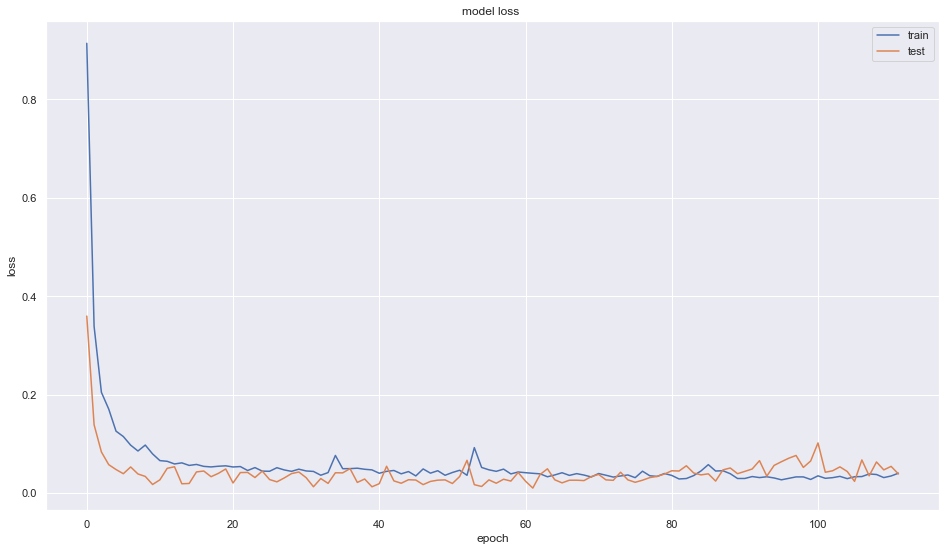

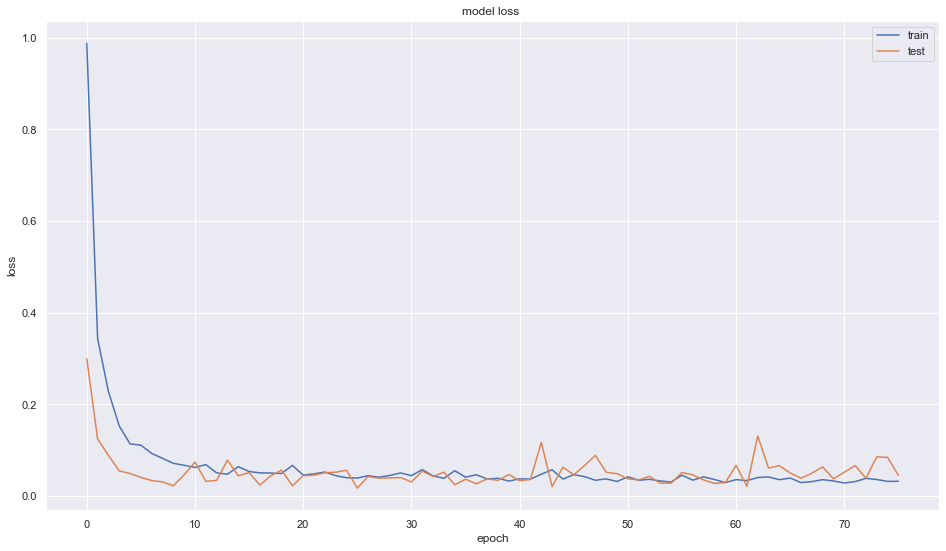

In [21]:
def create_model(X_train, y_train, X_test, y_test, X_val, y_val, number_of_layers=3, number_of_neurons=64, dropout=0.5):
    model = Sequential()
    model.add(Dense(number_of_neurons, activation='relu', input_shape =(X_train.shape[1],)))
    model.add(Dropout(dropout))
    for i in range(number_of_layers):
        model.add(Dense(number_of_neurons, activation='relu'))
        model.add(Activation('relu'))
        model.add(Dropout(dropout))

    model.add(Dense(units = 1))


    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    early_stoping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)

    model.compile(optimizer='adam', loss='mse')

    hist = model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_data=(X_val, y_val),
              callbacks=[reduce_lr, early_stoping], verbose = 0)

    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss, hist, model

def find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val):
    best_loss = 99999999
    best_hist = ""
    best_model = ""

    for layer in layers:
        for neuron in neurons:
            for dropout in dropouts:
                loss, hist, model = create_model(X_train, y_train, X_test, y_test, X_val, y_val, number_of_layers=layer, 
                                          number_of_neurons=neuron, dropout=dropout)
                if loss < best_loss:
                    best_loss = loss
                    best_hist = hist
                    best_model = model
                    print("Number of layers: "+str(layer) + ", Neurons: " + str(neuron) + 
                          ", Dropout: " + str(dropout) + ", Loss: " +  str(loss))
    plot_history(best_hist)
    return best_loss, best_hist, best_model

def plot_history(history):
    plt.figure(figsize=(16,9))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss ')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    
layers = [2,3,4]
neurons = [32, 64, 128, 256]
dropouts = [0.2, 0.4]

print("Normal dataset")
best_loss, best_hist, best_model = find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val)
print("Shuffled dataset")
best_loss_shuffle, best_hist_shuffle, best_model_shuffle = find_best_model(layers, neurons, dropouts, X_train_shuffle, y_train_shuffle, 
                                                                           X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle)

Text(0.5, 0, 'Random Forest Feature Importance')

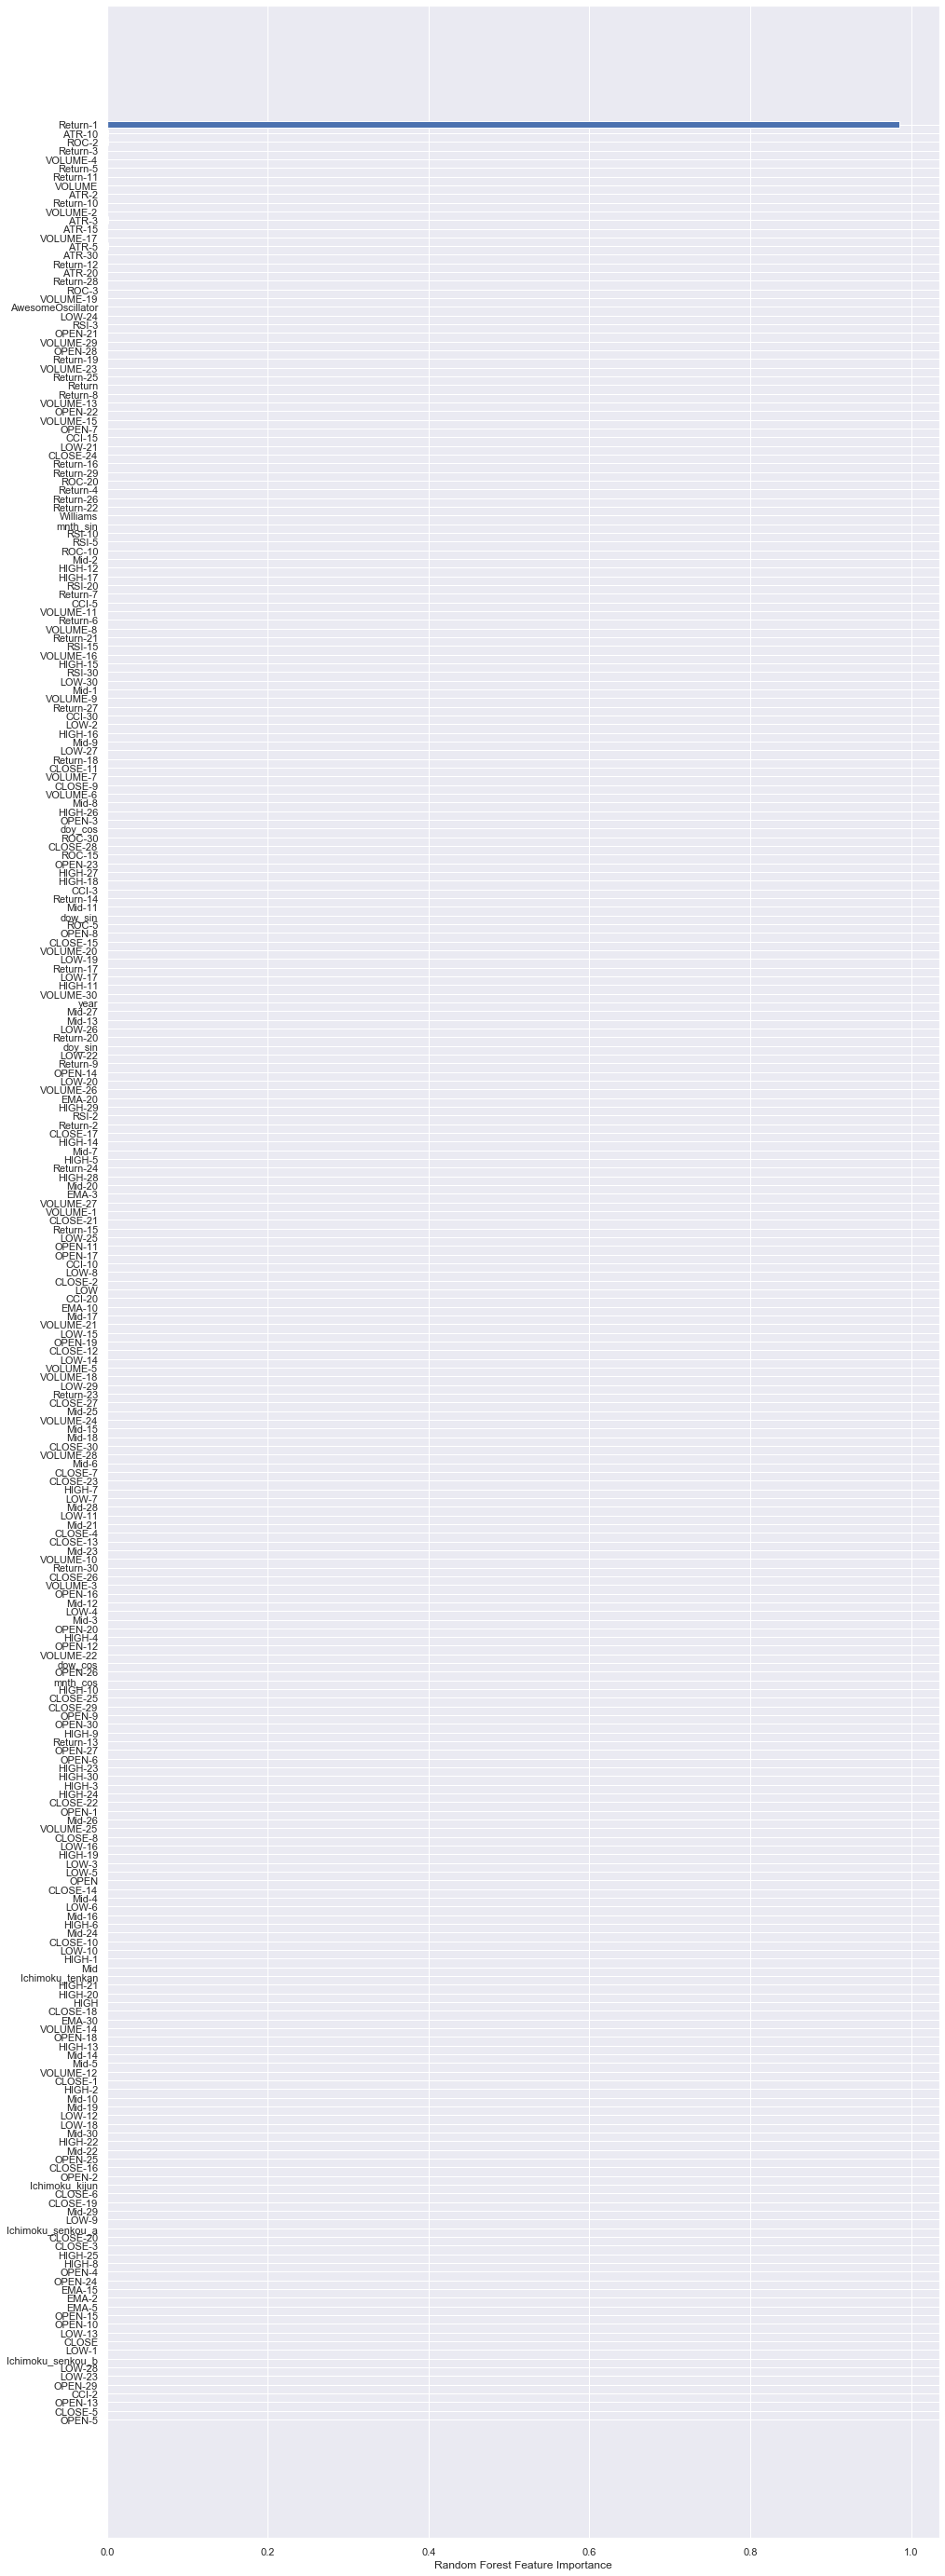

In [27]:

sorted_idx = rf_shuffle.feature_importances_.argsort()
fig = plt.figure(figsize=(16,50))
plt.barh(X.columns[sorted_idx], regr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [28]:
important_columns = X.columns[sorted_idx[-10:]].tolist()
X_new = X[important_columns]
X_new.head()

,Return-10,ATR-2,VOLUME,Return-11,Return-5,VOLUME-4,Return-3,ROC-2,ATR-10,Return-1
DATE,,,,,,,,,,
1993-03-18,-0.554348,0.386233,59300.0,0.417348,-0.273547,643600.0,0.484582,0.000518,0.402363,-0.620595
1993-03-19,-0.278274,0.333747,66900.0,-0.554348,-1.028320,310800.0,-0.000198,0.000338,0.390253,0.624992
1993-03-22,2.234730,0.401260,183400.0,-0.278274,0.484582,30800.0,-0.620595,-1.172798,0.398105,-0.620774
1993-03-23,-0.341831,0.278790,55200.0,2.234730,-0.000198,21800.0,0.624992,-0.347121,0.373927,-0.555472
1993-03-24,0.205758,0.373701,37200.0,-0.341831,-0.620595,59300.0,-0.620774,0.209520,0.383395,0.209515


Performance on train: 0.0015517431159284944 performance on test: 0.0020208321195734026
Performance on shuffled train: 0.0017322037587922357 performance on shuffled test: 0.0014649172008031565
Normal dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.054541812791274145
Number of layers: 2, Neurons: 32, Dropout: 0.4, Loss: 0.04115749413004288
Number of layers: 2, Neurons: 64, Dropout: 0.4, Loss: 0.03421838097847425
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.00957018140130318
Number of layers: 2, Neurons: 256, Dropout: 0.2, Loss: 0.0056538746735224354
Shuffled dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.06562272491363379
Number of layers: 2, Neurons: 64, Dropout: 0.2, Loss: 0.04554739672404069
Number of layers: 2, Neurons: 64, Dropout: 0.4, Loss: 0.041018141783200776
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.013078961613086554
Number of layers: 2, Neurons: 256, Dropout: 0.2, Loss: 0.008543053842507876
Number of layers: 2, Neuro

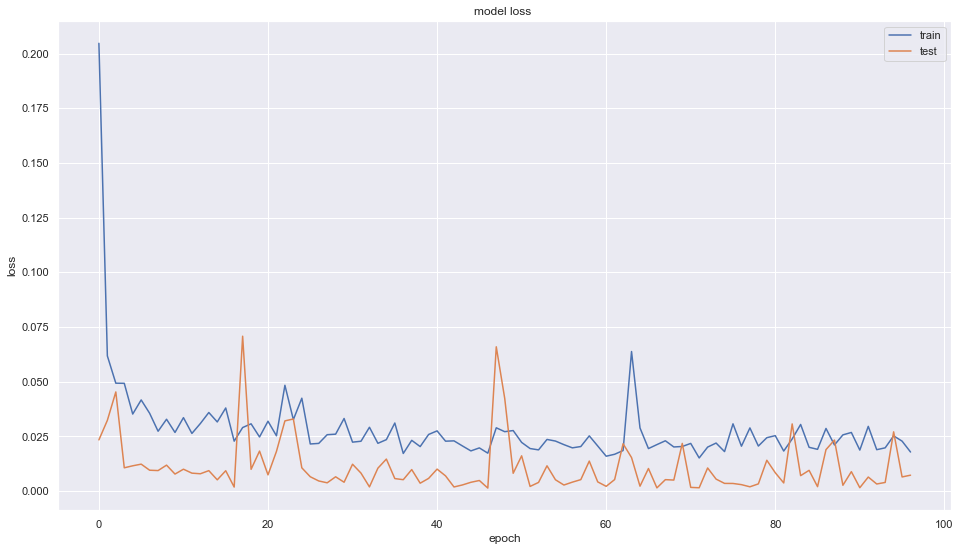

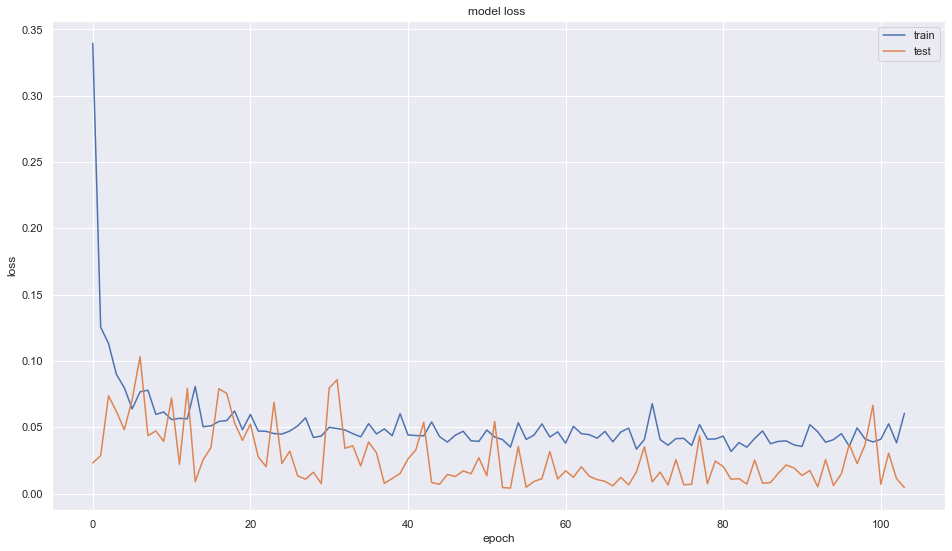

In [30]:
#Train test split without shuffle
X_train, y_train, X_test, y_test, X_val, y_val = split_data(X_new,y,False)

#Train test split with shuffle
X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle = split_data(X_new,y,True)

rf = random_forest(X_train, y_train, X_test, y_test, False)
rf_shuffle = random_forest(X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, True)

print("Normal dataset")
best_loss, best_hist, best_model = find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val)
print("Shuffled dataset")
best_loss_shuffle, best_hist_shuffle, best_model_shuffle = find_best_model(layers, neurons, dropouts, X_train_shuffle, y_train_shuffle, 
                                                                           X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle)

In [100]:
def compute_confusion_matrix(model, X_test, y_test):
    y_pred_test = model.predict(X_test)
    
    if isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.flatten()
    
    confusion_matrix = pd.DataFrame()
    confusion_matrix = pd.DataFrame(columns = ["Actual Positive", "Actual Negative"], 
                                    index = ["Predicted Positive", "Predicted Negative"])

    confusion_matrix.iloc[0,0] =  np.sum(np.where((y_pred_test>0) & (y_test.values>0), 1, 0)) #TP
    confusion_matrix.iloc[1,0] =  np.sum(np.where((y_pred_test<0) & (y_test.values>0), 1, 0)) #FN
    confusion_matrix.iloc[0,1] =  np.sum(np.where((y_pred_test>0) & (y_test.values<0), 1, 0)) #FP
    confusion_matrix.iloc[1,1] =  np.sum(np.where((y_pred_test<0) & (y_test.values<0), 1, 0)) #TN

    print(confusion_matrix)

print("Random Forest Confusion Matrix")
compute_confusion_matrix(rf_shuffle, X_test_shuffle, y_test_shuffle)

print("\n\nNeural Network Confusion Matrix")
compute_confusion_matrix(best_model, X_test, y_test)

Random Forest Confusion Matrix
                   Actual Positive Actual Negative
Predicted Positive             330               0
Predicted Negative               1             317


Neural Network Confusion Matrix
                   Actual Positive Actual Negative
Predicted Positive             351               9
Predicted Negative               1             286
